## Check why NMF is unbalanced, possibly find another implementation
## VGG_BN => Re-run images
## Color t

In [2]:
%load_ext autoreload
%autoreload 2
from pipeline import get_maps, normalized, normalized_k, normalized_all, gen_maps, show_maps
from helpers import load_image, load_image2

import numpy as np

import matplotlib.pyplot as plt
#%autoreload 2
%matplotlib inline

#Datastructure
from collections import OrderedDict

import skimage

DATA_PATH = '../data/'

In [3]:
def image_stats(image):
    l = image[:,:,0]
    a = image[:,:,1]
    b = image[:,:,2]
    (lMean, lStd) = (l.mean(), l.std())
    (aMean, aStd) = (a.mean(), a.std())
    (bMean, bStd) = (b.mean(), b.std())
    
    # return the color statistics
    return (lMean, lStd, aMean, aStd, bMean, bStd)

#https://www.pyimagesearch.com/2014/06/30/super-fast-color-transfer-images/
#source = color stats we want to match to target
def color_transfer(content, style):
    # compute color statistics for the source and target images
    (lMeanSrc, lStdSrc, aMeanSrc, aStdSrc, bMeanSrc, bStdSrc) = image_stats(content)
    (lMeanTar, lStdTar, aMeanTar, aStdTar, bMeanTar, bStdTar) = image_stats(style)
    
    # subtract the means from the target image
    l = content[:, :, 0]
    a = content[:, :, 1]
    b = content[:, :, 2]
    
    l -= lMeanSrc
    a -= aMeanSrc
    b -= bMeanSrc
    
    l = ( lStdSrc / lStdTar) * l
    a = ( aStdSrc / aStdTar) * a
    b = ( bStdSrc / bStdTar) * b
    
    '''
    # scale by the standard deviations
    l = (lStdTar / lStdSrc) * l
    a = (aStdTar / aStdSrc) * a
    b = (bStdTar / bStdSrc) * b
    ''' 
    
    l += lMeanTar
    a += aMeanTar
    b += bMeanTar
    
    l = np.clip(l, 0, 100)
    
    #fix l
    #l = content[:, :, 0]
    
    transfer = np.array([l, a, b])
    transfer = np.swapaxes(transfer, axis1=0, axis2=2)
    transfer = np.swapaxes(transfer, axis1=0, axis2=1)
    
    #print(transfer.max())
    #print(transfer.min())
    
    return transfer

#slow and not better than skimage
def rgb_to_lab(img):
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
                rgb = sRGBColor(img[i,j,0], img[i,j,1], img[i,j,2])
                lab = convert_color(rgb, LabColor)
                img[i,j,0] = lab.lab_l
                img[i,j,1] = lab.lab_a
                img[i,j,2] = lab.lab_b
            
    return img;

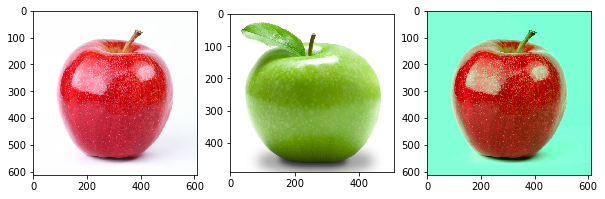

In [8]:
source_path='apple/2.jpg'
style_path='apple/1.jpg'
img_content = skimage.io.imread(DATA_PATH + source_path)
img_style = skimage.io.imread(DATA_PATH + style_path)

plt.figure(figsize=(10,6))
plt.subplot(131)
plt.imshow(img_content)
plt.subplot(132)
plt.imshow(img_style)

img_c_lab = skimage.color.rgb2lab(img_content)
img_s_lab = skimage.color.rgb2lab(img_style)

t = color_transfer(img_c_lab, img_s_lab)
plt.subplot(133)
plt.imshow(skimage.color.lab2rgb(t))

C:\Users\Adan\Anaconda3\envs\tensorflow\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 1142 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


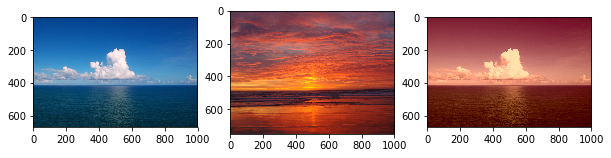

In [7]:
img_content = skimage.io.imread("../data/sunset/1.jpg")
img_style = skimage.io.imread("../data/sunset/2.jpg")

img_c_lab = skimage.color.rgb2lab(img_content/255)
img_s_lab = skimage.color.rgb2lab(img_style/255)

t = skimage.color.lab2rgb(color_transfer(img_c_lab, img_s_lab))
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.imshow(img_content)
plt.subplot(132)
plt.imshow(img_style)
plt.subplot(133)
plt.imshow(t)

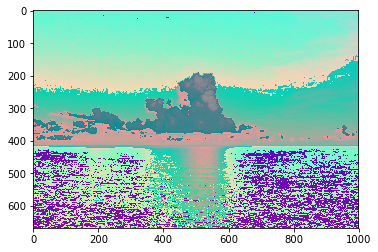

In [30]:
def lab_to_rgb(img):
    l = img[:,:,0]
    alpha = img[:,:,1]
    beta = img[:,:,2]
    
    L = np.sqrt(3.0) / 3.0 * l + np.sqrt(6) / 6.0 * alpha + np.sqrt(2) / 2.0 * beta;
    M = np.sqrt(3.0) / 3.0 * l + np.sqrt(6) / 6.0 * alpha - np.sqrt(2) / 2.0 * beta;
    S = np.sqrt(3.0) / 3.0 * l - np.sqrt(6) / 3.0 * alpha - 0 * beta;

    L = np.power(10.0, L);
    M = np.power(10.0, M);
    S = np.power(10.0, S);

    R = 4.4679*L - 3.5873*M + 0.1193*S;
    G = -1.2186*L + 2.3809*M - 0.1624*S;
    B = 0.0497*L - 0.2439*M + 1.2045*S;
    
    transfer = np.array([R, G, B])
    transfer = np.swapaxes(transfer, axis1=0, axis2=2)
    transfer = np.swapaxes(transfer, axis1=0, axis2=1)

    return transfer

def rgb_to_lab(img):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]

    L = 0.3811*R + 0.5783*G + 0.0402*B;
    M = 0.1967*R + 0.7244*G + 0.0782*B;
    S = 0.0241*R + 0.1288*G + 0.8444*B;

    L = np.log10(L)
    M = np.log10(M)
    S = np.log10(S)

    l = 1.0 / np.sqrt(3)*L + 1.0 / np.sqrt(3)*M + 1.0 / np.sqrt(3)*S;
    alpha = 1.0 / np.sqrt(6)*L + 1.0 / np.sqrt(6)*M - 2 / np.sqrt(6)*S;
    beta = 1.0 / np.sqrt(2)*L - 1.0 / np.sqrt(2)*M + 0 * S;
    
    transfer = np.array([l, alpha, beta])
    transfer = np.swapaxes(transfer, axis1=0, axis2=2)
    transfer = np.swapaxes(transfer, axis1=0, axis2=1)

    return transfer

img_content = skimage.io.imread("../data/sunset/1.jpg")
img_style = skimage.io.imread("../data/sunset/2.jpg")

c = rgb_to_lab(img_content/255)
s = rgb_to_lab(img_style/255)
t = color_transfer(c,s)
f = lab_to_rgb(t)

plt.imshow(f)

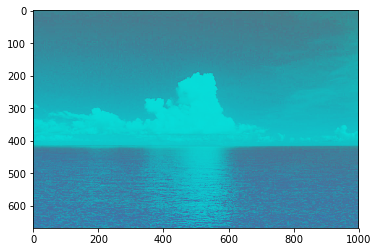

In [31]:
f2 = (normalized(f)*255).astype(np.int8)
plt.imshow(f2)

C:\Users\Adan\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\color\colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 822 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


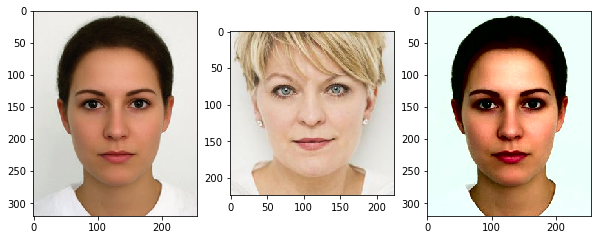

In [33]:
img_content = skimage.io.imread("../data/face/1.jpg")

img_style = skimage.io.imread("../data/face/2.jpg")

img_c_lab = skimage.color.rgb2lab(img_content/255)
img_s_lab = skimage.color.rgb2lab(img_style/255)

t = skimage.color.lab2rgb(color_transfer(img_c_lab, img_s_lab))

plt.figure(figsize=(10,6))
plt.subplot(131)
plt.imshow(img_content)

plt.subplot(132)
plt.imshow(img_style)

plt.subplot(133)
plt.imshow(t)

In [39]:
maps = gen_maps(image1_path="../data/face/1.jpg", image2_path="../data/face/2.jpg", K=10, layer_name="conv4_4", normalize_per_k=False)

In [44]:
W = maps[0]
H = maps[1]
W = np.swapaxes(W, axis1=2, axis2=1)
W = np.swapaxes(W, axis1=0, axis2=1)

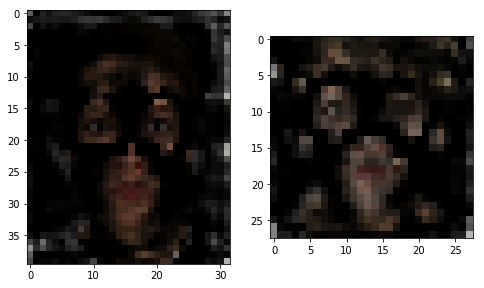

In [45]:
from pipeline import normalized

img_content_small = skimage.transform.resize(img_content, (W[0].shape), mode="constant" )  

W[1] = normalized(W[1])
H[1] = normalized(H[1])

img_content_small[:,:,0] = np.multiply(W[1], img_content_small[:,:,0])
img_content_small[:,:,1] = np.multiply(W[1], img_content_small[:,:,1])
img_content_small[:,:,2] = np.multiply(W[1], img_content_small[:,:,2])

img_style_small = skimage.transform.resize(img_style, (H[0].shape), mode="constant" )  

img_style_small[:,:,0] = np.multiply(H[1], img_style_small[:,:,0])
img_style_small[:,:,1] = np.multiply(H[1], img_style_small[:,:,1])
img_style_small[:,:,2] = np.multiply(H[1], img_style_small[:,:,2])

plt.figure(figsize=(8,6))
plt.subplot(121)
plt.imshow(img_content_small)

plt.subplot(122)
plt.imshow(img_style_small)


In [65]:
import tensorflow as tf
    
#img in LAB space
img_content = tf.placeholder(shape=[None, None, 3], dtype=tf.float32)
img_style = tf.placeholder(shape=[None, None, 3], dtype=tf.float32)


#fix L
img_init_L = tf.constant(img_content_small[:,:,0], dtype=tf.float32)
img_init_alpha = tf.Variable(img_content_small[:,:,1], dtype=tf.float32)
img_init_beta = tf.Variable(img_content_small[:,:,2], dtype=tf.float32)

Ws = tf.Variable(W, dtype=tf.float32)
Hs = tf.Variable(H, dtype=tf.float32)

#sum of masks of means 

#y = tf.multiply() 

   
'''
y = tf.add(tf.pow(tf.sub(1.0, x1_data), 2.0), 
tf.mul(100.0, tf.pow(tf.sub(x2_data, tf.pow(x1_data, 2.0)), 2.0)), 'y')

opt = tf.train.GradientDescentOptimizer(0.0035)
train = opt.minimize(y)

sess = tf.Session()

'''



TypeError: multiply() missing 2 required positional arguments: 'x' and 'y'

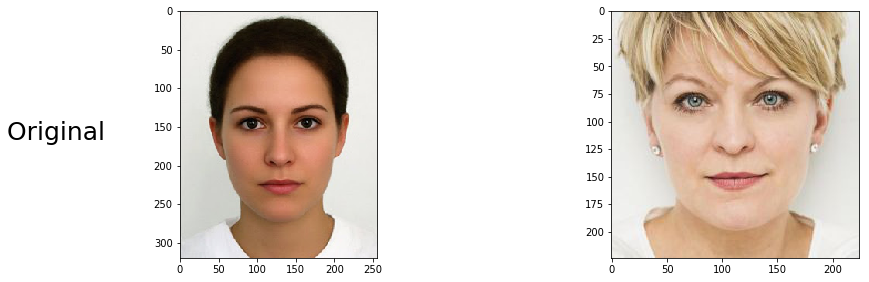

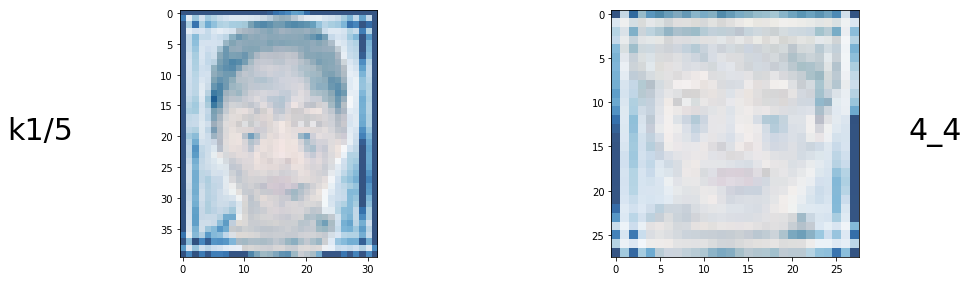

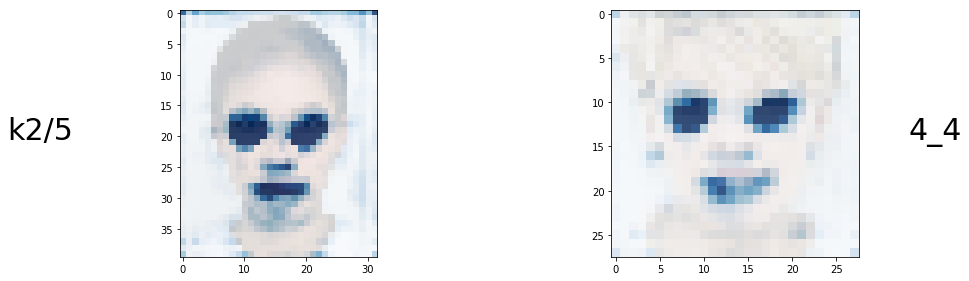

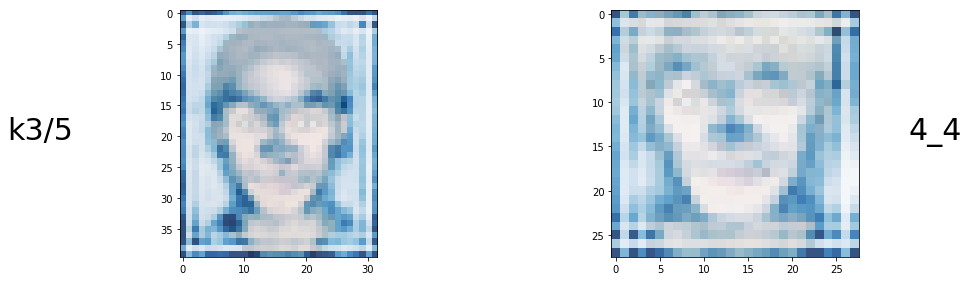

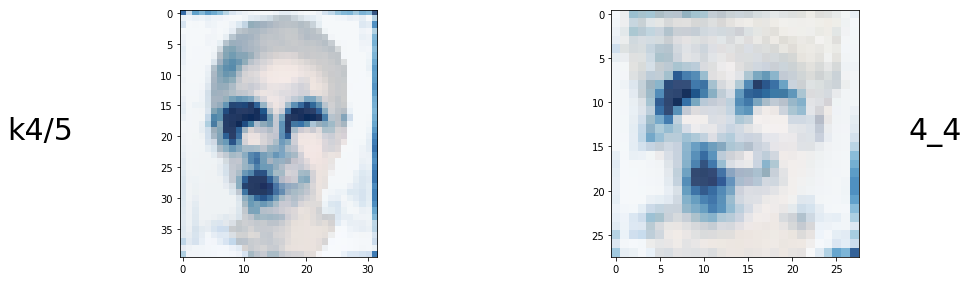

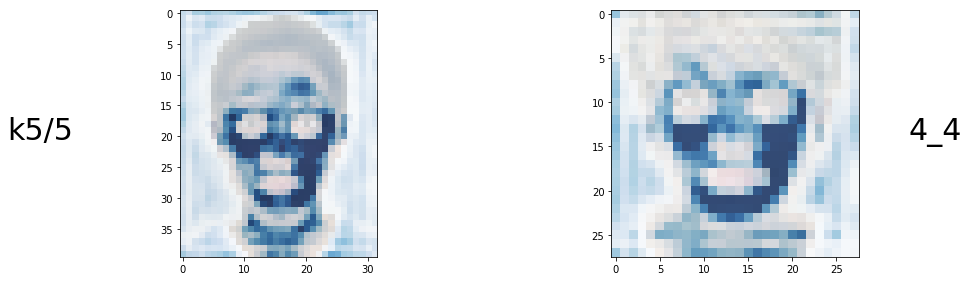

In [47]:
show_maps(image1_path="../data/face/1.jpg", image2_path="../data/face/2.jpg", K=K, layer_name="conv4_4", cmap="Blues", normalize_per_k=False)

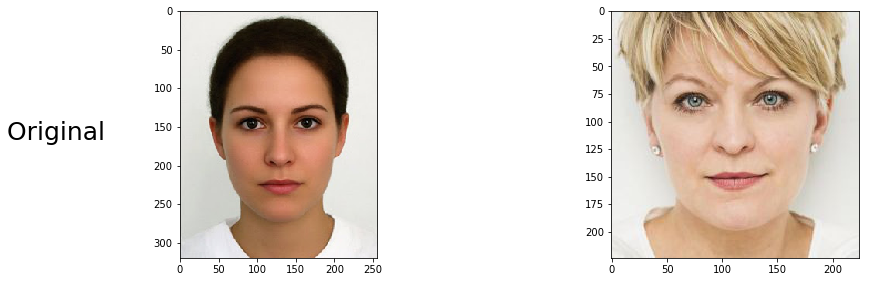

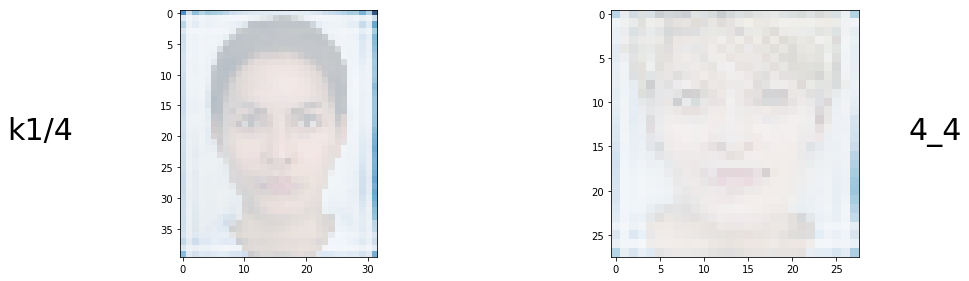

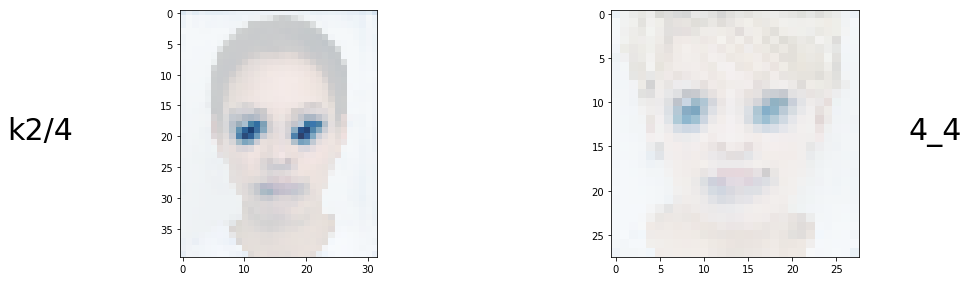

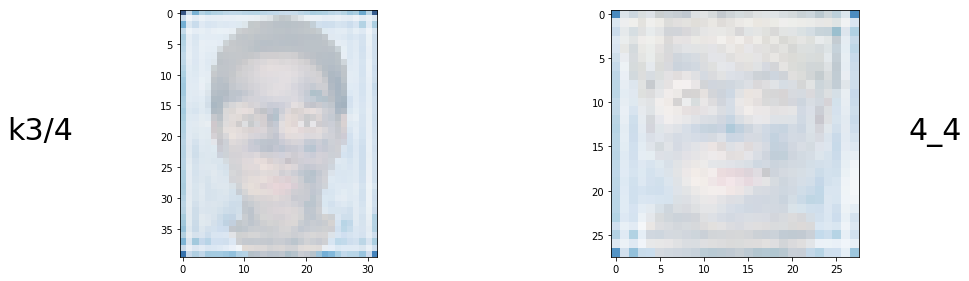

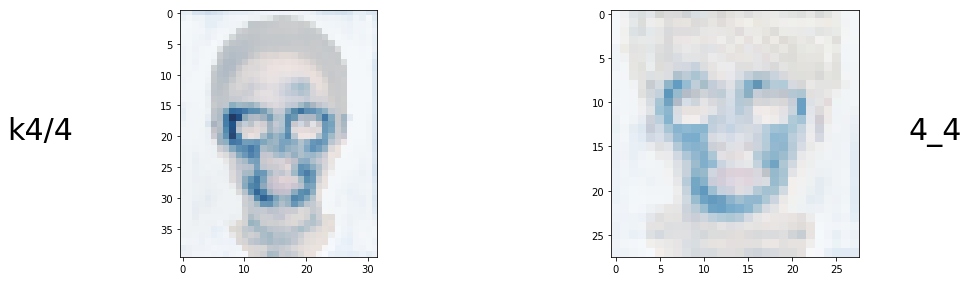

In [152]:
show_maps(image1_path="../data/face/1.jpg", image2_path="../data/face/2.jpg", K=K, layer_name="conv4_4", cmap="Blues", normalize_per_k=True)